## Data Analysis 

#### Section 0: Exploratory Data Analysis
#### Section 1: LASSO Models 
#### Section 2: Ridge Models 
#### Section 3: ElasticNet Models  
#### Section 4: Cross validation across regression regularization models
#### Section 5: Neural Network Models
#### Section 6: OLS Models (CHOSEN MODEL)

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
import math
from sklearn.preprocessing import MinMaxScaler
from keras.layers.core import Dense 
from keras.models import Sequential
import tensorflow as tf
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.regression import linear_model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler


#warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_context('notebook') 
sns.set_style('ticks')

In [2]:
df_test = pd.read_csv("ATM_test.csv")
df_train = pd.read_csv("ATM_training.csv")

In [3]:
y_train = df_train.iloc[:,-1]
x_train = df_train.iloc[:,0:6]
x_test = df_test.iloc[:,0:6]
y_test = df_test.iloc[:,-1]

## Section 0: Exploratory Data Analysis

In [4]:
df_train.describe()

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
count,22000.000000,22000.000000,22000.00000,22000.000000,22000.000000,22000.000000,22000.000000
mean,7.316373,7.937455,0.70200,0.714091,0.102455,0.301591,54.652818
std,4.118692,3.673415,0.45739,0.451857,0.303252,0.458959,25.099767
min,0.800000,0.000000,0.00000,0.000000,0.000000,0.000000,11.668197
25%,1.050000,4.000000,0.00000,0.000000,0.000000,0.000000,18.500386
50%,9.890000,9.000000,1.00000,1.000000,0.000000,0.000000,68.240749
75%,10.070000,11.000000,1.00000,1.000000,0.000000,1.000000,71.345778
max,10.830000,17.000000,1.00000,1.000000,1.000000,1.000000,103.964065


In [5]:
df_train['High'].value_counts()

0    15365
1     6635
Name: High, dtype: int64

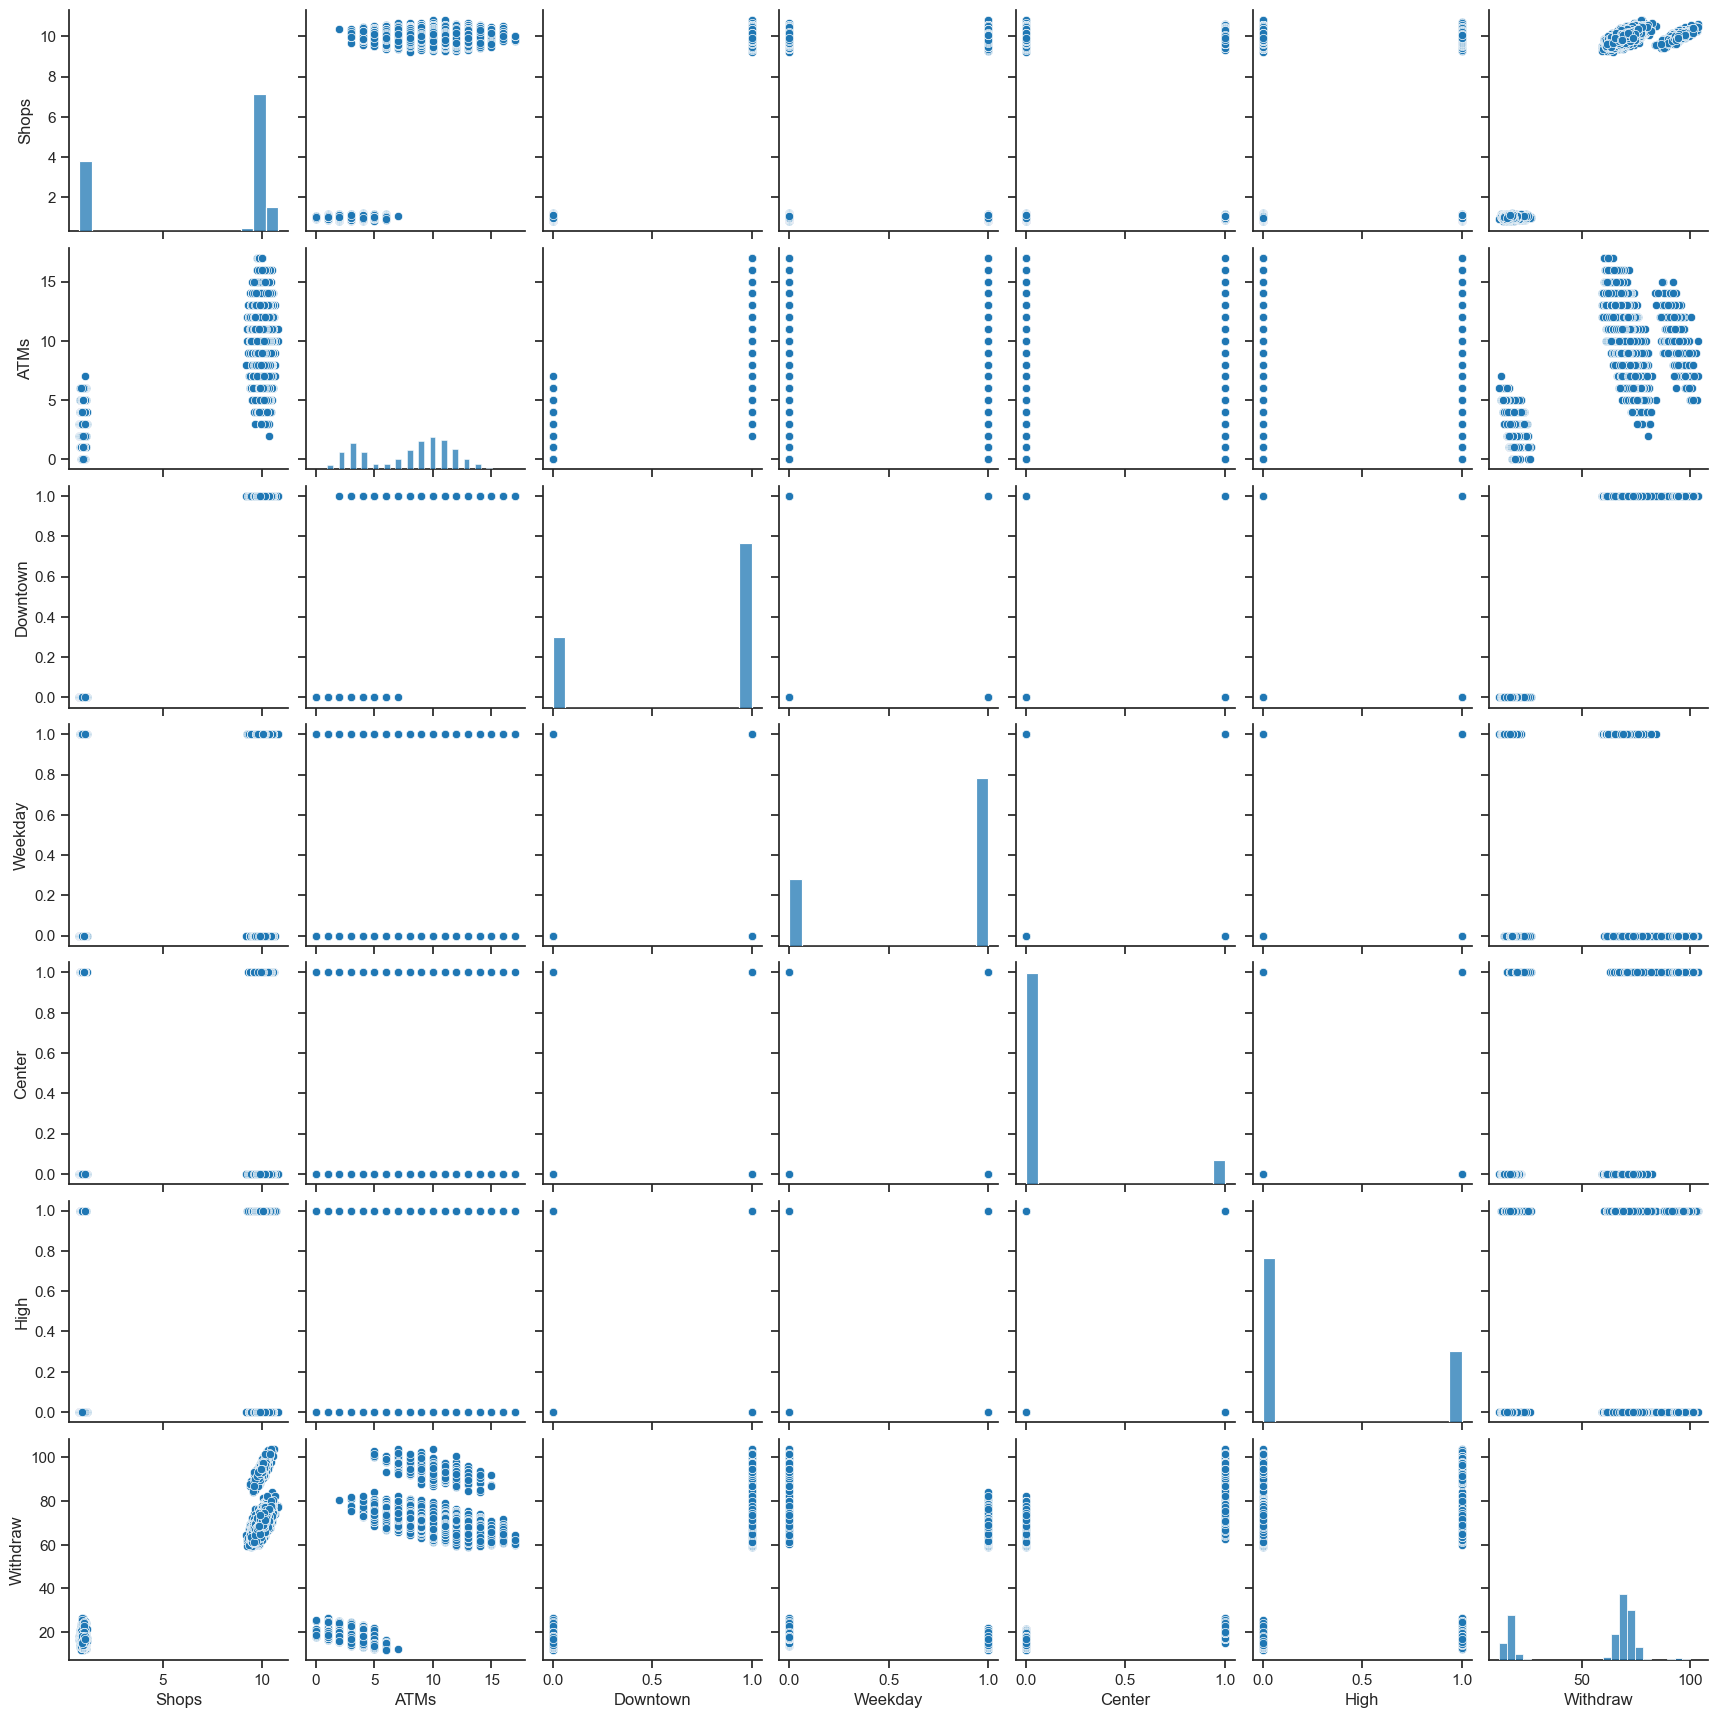

In [6]:
sns.pairplot(df_train)
plt.show()

In [7]:
correlations = df_train.corr()
correlations

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
Shops,1.000000,0.872903,0.999131,0.013014,0.000004,0.001820,0.985797
ATMs,0.872903,1.000000,0.873726,0.009766,-0.003306,-0.002616,0.824030
Downtown,0.999131,0.873726,1.000000,0.012664,-0.000101,0.001782,0.983574
Weekday,0.013014,0.009766,0.012664,1.000000,-0.007153,-0.006793,-0.050470
Center,0.000004,-0.003306,-0.000101,-0.007153,1.000000,0.010521,0.088103
High,0.001820,-0.002616,0.001782,-0.006793,0.010521,1.000000,0.021275
Withdraw,0.985797,0.824030,0.983574,-0.050470,0.088103,0.021275,1.000000


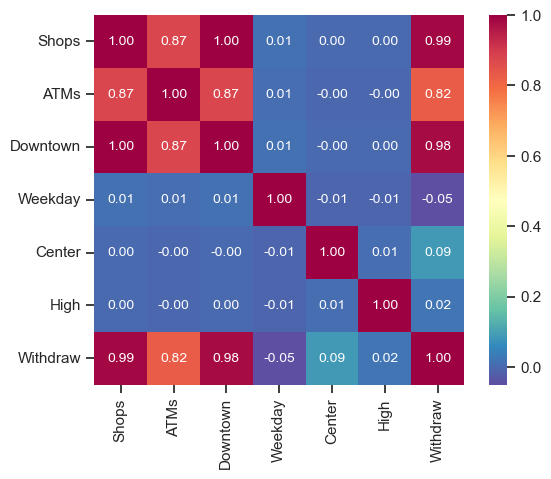

In [8]:
corrmat = df_train.corr()
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=df_train.columns, 
                 xticklabels=df_train.columns, 
                 cmap="Spectral_r")
plt.show()

## Section 1: LASSO Models

### Model & Variable Selection

AIC Criterion

In [9]:
start_time = time.time()
lasso_lars_ic = make_pipeline(
    StandardScaler(), LassoLarsIC(criterion="aic", normalize=True) ).fit(x_train, np.ravel(y_train))
fit_time = time.time() - start_time

In [10]:
results = pd.DataFrame( 
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

BIC Criterion

In [11]:
lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(x_train, np.ravel(y_train))
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

In [12]:
def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

results.style.apply(highlight_min)

,AIC criterion,BIC criterion
alphas,,
0.166815,22000.000000,22000.000000
0.014908,793.233716,801.232514
0.010543,624.525863,640.523459
0.003281,394.221414,418.217807
0.003123,382.380376,414.375567
0.000097,245.007077,285.001065
0.000000,230.360397,278.353183


Graphing BIC and AIC Values

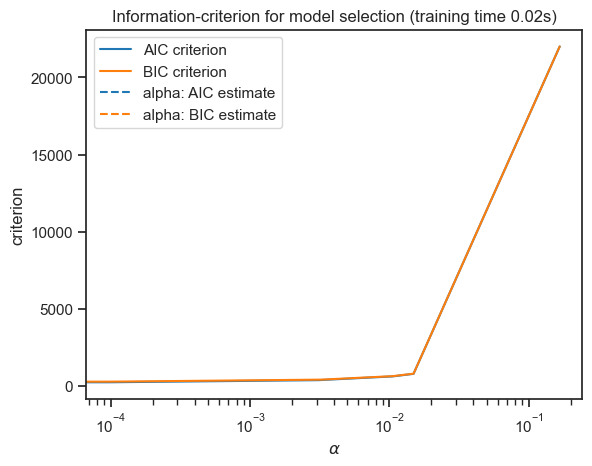

In [13]:
ax = results.plot()

ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)

ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection (training time {fit_time:.2f}s)"
)

Cross Validation

In [14]:
start_time = time.time()
model = make_pipeline(StandardScaler(), LassoCV(cv=30)).fit(x_train, np.ravel(y_train))
fit_time = time.time() - start_time

In [15]:
optimal_alpha_cv = model[-1].alpha_

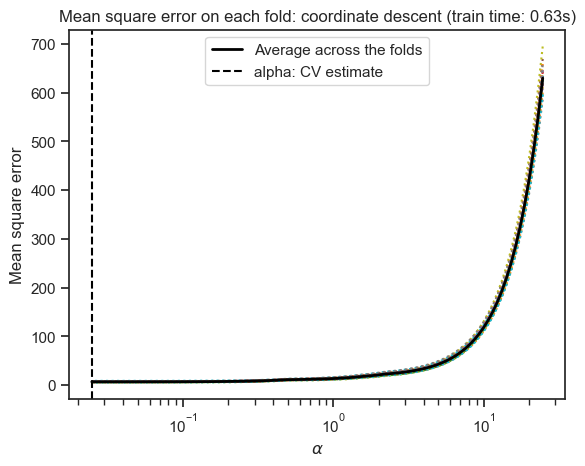

In [16]:
ymin, ymax = 2300, 3800
lasso = model[-1]
plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title(
    f"Mean square error on each fold: coordinate descent (train time: {fit_time:.2f}s)"
)

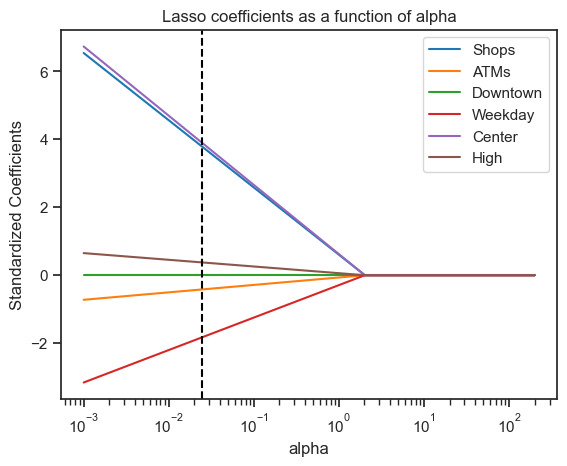

In [17]:
alphas = np.linspace(0.001,200,100)
lasso = Lasso(max_iter=10000, normalize=True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.legend(labels=x_train.columns)
plt.ylabel('Standardized Coefficients')
plt.axvline(model[-1].alpha_, linestyle="--", color="black", label="alpha: CV estimate")
plt.title('Lasso coefficients as a function of alpha');

### Lasso Models

Best CV Model

In [18]:
lassocv_best = Lasso(alpha=model[-1].alpha_)
lassocv_best.fit(x_train, y_train)
lassoCV_coef = lassocv_best.coef_
lassoCV_MSE = mean_squared_error(y_test, lassocv_best.predict(x_test))

In [19]:
pd.DataFrame(lassoCV_coef, index = x_train.columns).T

,Shops,ATMs,Downtown,Weekday,Center,High
0,6.81003,-1.026577,-0.0,-3.369581,6.932312,0.842595


Best AIC Model

In [20]:
lassoaic_best = Lasso(alpha=alpha_aic)
lassoaic_best.fit(x_train, y_train)
lassoAIC_coef = lassoaic_best.coef_
lassoAIC_MSE = mean_squared_error(y_test, lassoaic_best.predict(x_test))

/var/folders/qd/df89glvj5jx3vfj1gz7sd49c0000gn/T/ipykernel_5814/1771561290.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lassoaic_best.fit(x_train, y_train)
/Users/benedictachun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/benedictachun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69013.65170339271, tolerance: 1385.9332394297514
  model = cd_fast.enet_coordinate_descent(


In [21]:
pd.DataFrame(lassoAIC_coef, index = x_train.columns).T

,Shops,ATMs,Downtown,Weekday,Center,High
0,9.967376,-1.016007,-28.52934,-3.498383,7.194105,0.956705


Best BIC Model

In [22]:
lassobic_best = Lasso(alpha=alpha_bic)
lassobic_best.fit(x_train, y_train)
lassoBIC_coef = lassobic_best.coef_
lassoBIC_MSE = mean_squared_error(y_test, lassobic_best.predict(x_test))

/var/folders/qd/df89glvj5jx3vfj1gz7sd49c0000gn/T/ipykernel_5814/3195414357.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lassobic_best.fit(x_train, y_train)
/Users/benedictachun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/benedictachun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69013.65170339271, tolerance: 1385.9332394297514
  model = cd_fast.enet_coordinate_descent(


In [23]:
pd.DataFrame(lassoBIC_coef, index = x_train.columns).T

,Shops,ATMs,Downtown,Weekday,Center,High
0,9.967376,-1.016007,-28.52934,-3.498383,7.194105,0.956705


## Section 2: Ridge Regression Model

In [24]:
alphas = np.exp(np.linspace(-10,20,500)) 

In [25]:
#use CV to find the best alpha value for the data 

ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(x_train, y_train)
ridgecv.alpha_

4.5399929762484854e-05

In [26]:
#pass the best alpha value into the ridge regression and fit it

ridge = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge.fit(x_train, y_train)

mse = mean_squared_error(y_test, ridge.predict(x_test))

In [27]:
pd.DataFrame(ridge.coef_, index = x_train.columns).T

,Shops,ATMs,Downtown,Weekday,Center,High
0,10.445331,-1.010232,-32.868491,-3.499759,7.19331,0.956679


In [28]:
y_pred = ridge.predict(x_test)

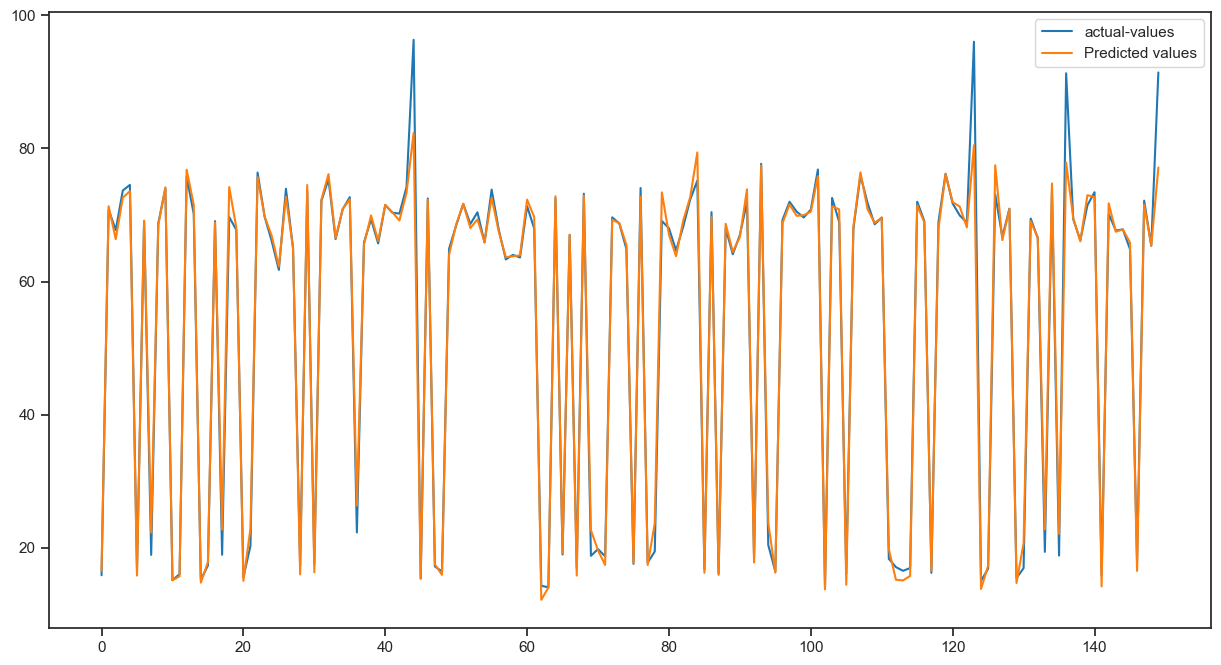

In [29]:
# importing the module
import matplotlib.pyplot as plt

# fitting the size of the plot
plt.figure(figsize = (15, 8))

# plotting the graphs for actual-value and predicted values
plt.plot(y_test, label = "actual-values")
plt.plot(y_pred, label = "Predicted values")

# showing the plotting of predictive modelling technique
plt.legend()
plt.show()

## Section 3: Elastic Net Models

Dealing with categorical features

In [30]:
train=pd.get_dummies(df_train, drop_first=True)
test=pd.get_dummies(df_test, drop_first=True)

In [32]:
response = ['Withdraw']
predictors=[x for x in list(train.columns) if x not in response]

Elastic Net Model

----

Determine shrinkage parameter to choose optimal alpha value: Using cross validation method

In [33]:
x_train = train[predictors]
y_train = train[response]
# Determining optimal alpha value
enet_cv = ElasticNetCV(l1_ratio=[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99], normalize=True)
enet_cv.fit(train[predictors], np.ravel(train[response]))
enet = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_)

# Fitting the Elastic Net model to the training data
enet = enet.fit(x_train, np.ravel(y_train))

/Users/benedictachun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68275.12208909009, tolerance: 1385.9332394297514
  model = cd_fast.enet_coordinate_descent(


l1_ratio is almost close to 1. Thus, using cross-validation l1 lasso has an overly better performance than l2.

Calculate Mean squared Error and R2 value for the Elastic Net model

In [34]:
x = test[predictors]
y = test[response]

enet_score = enet.score(x, y)
predict_y = enet.predict(x)

# Mean squared Error of Elastic net model
mse = mean_squared_error(y, predict_y)

Plotting the Elastic net model predicted values against the actual observed values

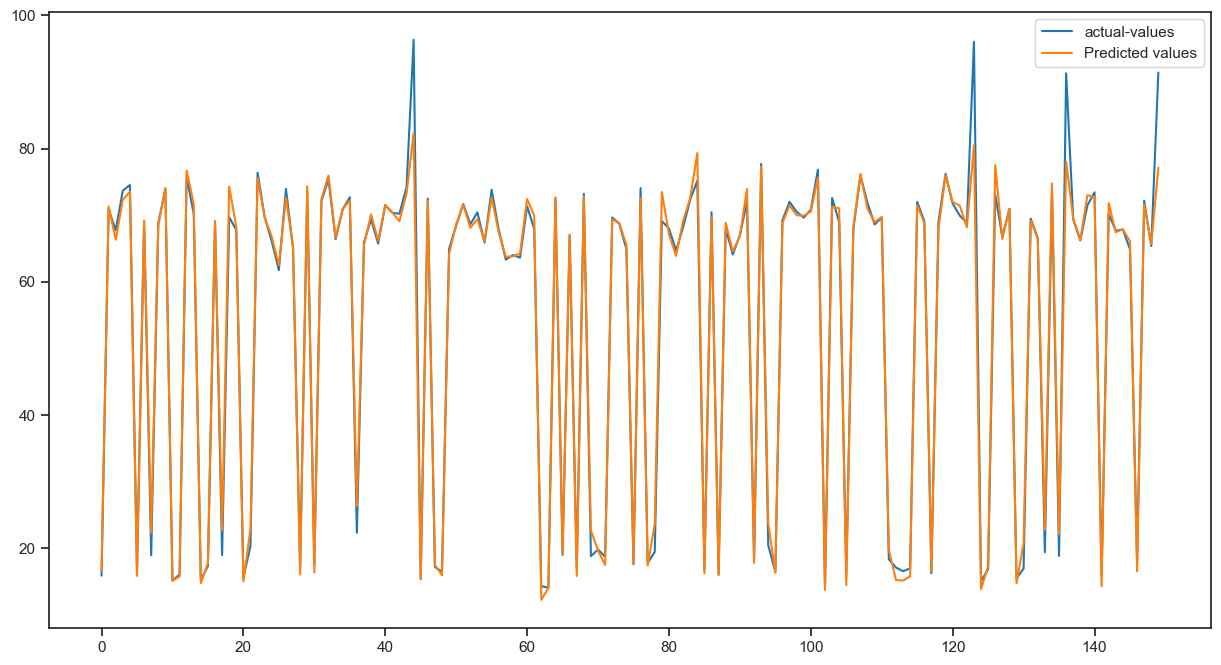

In [35]:
# fitting the size of the plot
plt.figure(figsize=(15, 8))
y_test = test[response]
y_pred = enet.predict(x_test)

# plotting the graphs for actual-value and predicted values
plt.plot(y_test, label = "actual-values")
plt.plot(y_pred, label = "Predicted values")

# showing the plotting of predictive modelling technique
plt.legend()
plt.show()

## Section 4: Cross validation across Regression Regularization models

Cross Validation across Lasso, Ridge and Elastic Net Regression models


Suggests which model best performs on the training dataset

In [36]:
# Use KFold for Cross validator
kfold = KFold(10, shuffle=True, random_state=1)

# Data frame column and row 
columns = ['CV MSE']
rows = ['Ridge', 'Lasso']

regressions = [lassoaic_best, ridge]
# Create Data frame that holds the performance on each model
results = pd.DataFrame(0.0, columns=columns, index=rows)

methods = {k: v for k, v in zip(rows, regressions)}
# Compute results for each model
keys = ['Ridge', 'Lasso']
for k in keys:
    scores = cross_val_score(methods[k], x_train, np.ravel(y_train), cv=kfold, scoring = 'neg_mean_squared_error')
    results.loc[k] = -1*np.mean(scores)
results.round(4)

/Users/benedictachun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/benedictachun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/benedictachun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62368.63765564013, tolerance: 1246.093717817849
  model = cd_fast.enet_coordinate_descent(
/Users/benedictachun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: UserWarning: With alpha=0, this algorith

/Users/benedictachun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62394.81732060635, tolerance: 1251.4492332121374
  model = cd_fast.enet_coordinate_descent(


,CV MSE
Ridge,6.2793
Lasso,6.2622


Suggests which model best performs on the test dataset

In [37]:
x_test = test[predictors]
y_test = test[response]

# Use KFold for Cross validator
kfold = KFold(10, shuffle=True, random_state=1)

# Data frame column and row 
columns = ['CV MSE']
rows = ['Ridge', 'Lasso']

regressions = [lassoaic_best, ridge]
# Create Data frame that holds the performance on each model
results = pd.DataFrame(0.0, columns=columns, index=rows)

methods = {k: v for k, v in zip(rows, regressions)}

# Compute results for each model
keys = ['Ridge', 'Lasso']
for k in keys:
    scores = cross_val_score(methods[k], x_test, np.ravel(y_test), cv=kfold, scoring = 'neg_mean_squared_error')
    results.loc[k] = -1*np.mean(scores)
results.round(4)

/Users/benedictachun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/benedictachun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/benedictachun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 429.7746548829103, tolerance: 8.172312688534642
  model = cd_fast.enet_coordinate_descent(
/Users/benedictachun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: UserWarning: With alpha=0, this algorith

,CV MSE
Ridge,8.2893
Lasso,8.2769


## Section 5: Neural Network Models

In [38]:
np.random.seed(1)
tf.random.set_seed(0)

NameError: name 'tf' is not defined

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

fitted_transformer = scaler.fit(x_train)
x_train_scaled = fitted_transformer.transform(x_train)

fitted_transformer = scaler.fit(x_test)
x_test_scaled = fitted_transformer.transform(x_test)

fitted_transformer = scaler.fit(y_test)
y_test_scaled = fitted_transformer.transform(y_test)

fitted_transformer = scaler.fit(y_train)
y_train_scaled = fitted_transformer.transform(y_train)

###Optimal Neural Network Model:
Sigmoid Activation



In [ ]:
'''model = Sequential()
model.add(Dense(6, input_dim=6, activation='sigmoid'))
model.add(Dense(6, activation='sigmoid'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()
history = model.fit(x_train_scaled, y_train_scaled, epochs=250, batch_size=20, verbose=2)
mean_squared_error(scaler.inverse_transform(y_test_scaled), scaler.inverse_transform(model.predict(x_test_scaled)))'''

"model = Sequential()\nmodel.add(Dense(6, input_dim=6, activation='sigmoid'))\nmodel.add(Dense(6, activation='sigmoid'))\nmodel.add(Dense(1, activation='linear'))\nmodel.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])\nmodel.summary()\nhistory = model.fit(x_train_scaled, y_train_scaled, epochs=250, batch_size=20, verbose=2)\nmean_squared_error(scaler.inverse_transform(y_test_scaled), scaler.inverse_transform(model.predict(x_test_scaled)))"

In [ ]:
'''y_pred = model.predict(x_test_scaled)
y_pred = scaler.inverse_transform(y_pred)
# fitting the size of the plot
plt.figure(figsize=(15, 8))

# plotting the graphs for actual-value and predicted values
plt.plot(y_test, label = "True Values")
plt.plot(y_pred, label = "Predicted values")
plt.title("Neural Network Sigmoid Activation Model True versus Predicted Values of Withdraw Variable from Test Data")

# showing the plotting of predictive modelling technique
plt.legend()
plt.show()'''

In [ ]:
'''plt.plot(history.history['mse'])
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error (MSE)")
plt.title("MSE Training Evaluation Over Epochs")
plt.show()'''

### Other models considered

*   Tanh Activation with no, one and two hidden layers
*   Relu Activation with one and no hidden layers



In [ ]:
'''model3 = Sequential()
model3.add(Dense(6, input_dim=6, activation='tanh'))
model3.add(Dense(6, activation='tanh'))
model3.add(Dense(1, activation='linear'))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.summary()
model3.fit(x_train_scaled, y_train_scaled, epochs=100, batch_size=20, verbose=0)
mean_squared_error(scaler.inverse_transform(y_test_scaled), scaler.inverse_transform(model3.predict(x_test_scaled)))'''

In [ ]:
'''model4 = Sequential()
model4.add(Dense(6, input_dim=6, activation='tanh'))
model4.add(Dense(1, activation='linear'))
model4.compile(loss='mean_squared_error', optimizer='adam')
model4.summary()
model4.fit(x_train_scaled, y_train_scaled, epochs=100, batch_size=20, verbose=0)
mean_squared_error(scaler.inverse_transform(y_test_scaled), scaler.inverse_transform(model4.predict(x_test_scaled)))'''

In [ ]:
'''model5 = Sequential()
model5.add(Dense(6, input_dim=6, activation='tanh'))
model5.add(Dense(6, activation='tanh'))
model5.add(Dense(6, activation='tanh'))
model5.add(Dense(1, activation='linear'))
model5.compile(loss='mean_squared_error', optimizer='adam')
model5.summary()
model5.fit(x_train_scaled, y_train_scaled, epochs=100, batch_size=20, verbose=0)
mean_squared_error(scaler.inverse_transform(y_test_scaled), scaler.inverse_transform(model5.predict(x_test_scaled)))'''

In [ ]:
'''model6 = Sequential()
model6.add(Dense(6, input_dim=6, activation='relu'))
model6.add(Dense(6, activation='relu'))
model6.add(Dense(1, activation='linear'))
model6.compile(loss='MSE', optimizer='adam')
model6.fit(x_train_scaled, y_train_scaled, epochs=100, batch_size=20, verbose=0)
mean_squared_error(scaler.inverse_transform(y_test_scaled), scaler.inverse_transform(model6.predict(x_test_scaled)))'''

In [ ]:
'''model2 = Sequential()
model2.add(Dense(6, input_dim=6, activation='relu'))
model2.add(Dense(1, activation='linear'))
model2.compile(loss='MSE', optimizer='adam')
model2.fit(x_train_scaled, y_train_scaled, epochs=100, batch_size=20, verbose=0)
mean_squared_error(scaler.inverse_transform(y_test_scaled), scaler.inverse_transform(model2.predict(x_test_scaled)))'''

## Section 6: OLS Models (Chosen Model)

Polynomial Feature Analysis for Interaction Terms

In [58]:
# Generates new feature matrix that consists of all possible polynomial combinations between features
x_interaction = PolynomialFeatures(6, interaction_only=True, include_bias=False)
x_interaction_transformation = x_interaction.fit_transform(x_train)

# Create Data frame including the interaction terms
interaction_df = pd.DataFrame(x_interaction_transformation, columns = x_interaction.get_feature_names())

# Fit new OLS model to check which interaction terms are significant
interaction_model = linear_model.OLS(y_train, interaction_df).fit()

In [59]:
# Use interaction terms that are statistically significant (p-value less than 0.05)
int_term1 = pd.DataFrame(interaction_model.pvalues[interaction_model.pvalues < 0.05])
#len(int_term1)

A p-value of 0.0001 was chosen to inspect the interaction terms with very high statistical significance as a p-value of 0.05 (from above) includes 58 possible interaction terms

In [60]:
pd.DataFrame(interaction_model.pvalues[interaction_model.pvalues < 0.00001])

,0
x0,0.000000e+00
x1,0.000000e+00
x2,5.493566e-48
x3,1.990873e-152
x4,1.583391e-15
x5,4.194337e-49
x0 x1,0.000000e+00
x0 x2,1.545197e-294
x0 x3,6.471103e-193
x0 x4,5.695539e-10


### Best and Chosen Model
Using the optimal interaction terms that are statistically significant, fit our OLS model

In [61]:
formula = 'Withdraw ~ Shops*Downtown*ATMs*Weekday*Center + Downtown*ATMs*Weekday*Center + Shops*ATMs*Weekday*Center + Shops*Downtown*Weekday*Center + Shops*Downtown*ATMs*Center + Shops*Downtown*ATMs*Weekday + Shops*Downtown*ATMs + Shops*Downtown*Weekday + Shops*Downtown*Center + Shops*Weekday*Center + Shops*ATMs*Center + Shops*ATMs*Weekday + Downtown*ATMs*Weekday + Downtown*ATMs*Center + Downtown*Weekday*Center + ATMs*Weekday*Center + Downtown*ATMs + Shops*Downtown + Shops*ATMs + Shops*Weekday + Shops*Center + Downtown*Weekday + Downtown*Center + ATMs*Weekday + ATMs*Center + Weekday*Center + High + Center + Weekday + Shops + Downtown + ATMs'

In [62]:
lm = smf.ols(formula, df_train).fit()

In [63]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.742e+06
Date:                Sun, 13 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:20:31   Log-Likelihood:                -15885.
No. Observations:               22000   AIC:                         3.184e+04
Df Residuals:                   21967   BIC:                         3.210e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             19.5674      0.721     27.140      0.000      18.154      20.981
Shops                                  0.9546      0.721      1.324      0.185      -0.458       2.367
Downtown                             -54.2717      2.082    -26.064      0.000     -58.353     -50.190
Shops:Downtown                        10.6236      0.747     14.225      0.000       9.160      12.087
ATMs                                  -1.3502      0.233     -5.788      0.000      -1.807      -0.893
Shops:ATMs                             0.3513      0.233      1.506      0.132      -0.106       0.808
Downtown:ATMs                          0.8958      0.300      2.981      0.003       0.307       1.485
Shops:Downtown:ATMs                   -0.4064      0.234     -1.737      0.082      -0.865       0.052
Weekday                               -3.6821      0.862     -4.273      0.000      -5.371      -1.993
Shops:Weekday                          1.6502      0.861      1.916      0.055      -0.038       3.338
Downtown:Weekday                       7.9008      2.487      3.176      0.001       3.025      12.776
Shops:Downtown:Weekday                -2.2778      0.892     -2.553      0.011      -4.027      -0.529
ATMs:Weekday                           0.6002      0.276      2.176      0.030       0.059       1.141
Shops:ATMs:Weekday                    -0.5939      0.276     -2.154      0.031      -1.134      -0.054
Downtown:ATMs:Weekday                 -1.1827      0.357     -3.312      0.001      -1.883      -0.483
Shops:Downtown:ATMs:Weekday            0.6528      0.277      2.360      0.018       0.111       1.195
Center                                 3.0535      2.273      1.343      0.179      -1.402       7.508
Shops:Center                           1.8672      2.286      0.817      0.414      -2.614       6.348
Downtown:Center                       12.8309      7.184      1.786      0.074      -1.251      26.912
Shops:Downtown:Center                 -1.1580      2.385     -0.485      0.627      -5.833       3.517
ATMs:Center                            0.1299      0.695      0.187      0.852      -1.232       1.492
Shops:ATMs:Center                     -0.1223      0.698     -0.175      0.861      -1.491       1.247
Downtown:ATMs:Center                  -1.6049      0.969     -1.656      0.098      -3.504       0.295
Shops:Downtown:ATMs:Center             0.2697      0.702      0.384      0.701      -1.106       1.645
Weekday:Center                         0.1754      2.787      0.063      0.950      -5.287       5.638
Shops:Weekday:Center                  -2.1318      2.792     -0.763      0.445      -7.605       3.341
Downtown:Weekday:Center              -19.8006      8.231     -2.406      0.016     -35.934      

### Test error MSE For our final chosen Model

In [64]:
test_error = mean_squared_error(y_test, lm.predict(x_test))
print(test_error)

0.23746042672169362


### Other models

In [65]:
lm = smf.ols('Withdraw ~ Shops + Downtown + ATMs + Weekday + Center + High', df_train).fit()
formula = 'Withdraw ~ Shops*Downtown*ATMs*Weekday*High + Downtown*ATMs*Weekday*High + Shops*ATMs*Weekday*High + Shops*Downtown*Weekday*High + Shops*Downtown*ATMs*High + Shops*Downtown*ATMs*Weekday + Shops*Downtown*ATMs + Shops*Downtown*Weekday + Shops*Downtown*High + Shops*Weekday*High + Shops*ATMs*High + Shops*ATMs*Weekday + Downtown*ATMs*Weekday + Downtown*ATMs*High + Downtown*Weekday*High + ATMs*Weekday*High + Downtown*ATMs + Shops*Downtown + Shops*ATMs + Shops*Weekday + Shops*High + Downtown*Weekday + Downtown*High + ATMs*Weekday + ATMs*High + Weekday*High + Center + High + Weekday + Shops + Downtown + ATMs'
lm = smf.ols(formula, df_train).fit()